In [164]:
from keras.layers import Dense, Activation, Dropout
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Flatten
from keras.layers import UpSampling2D

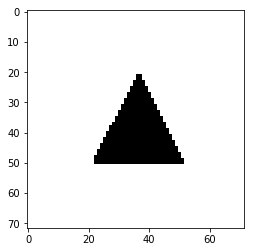

In [91]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(0, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(0)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(0, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

In [4]:
[X_train, Y_train] = generate_dataset_classification(300, 20)


Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [5]:
print(X_train.shape)
print('Y_train.shape : ', Y_train.shape)
Y_train = np_utils.to_categorical(Y_train, 3)
print('Y_train.shape : ', Y_train.shape)




(300, 5184)
Y_train.shape :  (300,)
Y_train.shape :  (300, 3)


In [6]:
lol = X_train[0]
print(lol.shape)

(5184,)


In [7]:
for i in range(5184):
    print(lol[i])

0.9605072904676347
0.9911950248257833
0.9564352714095101
0.9706473936420904
0.9878221295441916
0.9484733480260945
0.9322928772042306
0.9473848936897319
0.9890572193774723
0.9409057892263147
0.978749726090056
0.9980066400360847
0.9709141117299263
0.9644680299337002
0.9349256892270488
0.9515057702764449
0.9566496415168616
0.9370532252100573
0.9475573074816788
0.9635868895379026
0.9730772007742369
0.9566101923052168
0.9417031297617648
0.9349833511986245
0.9524181568794013
0.94324595588097
0.9929207300912823
0.9457188108787402
0.9609675520270414
0.989620239702146
0.9948077214709827
0.9902537605137888
0.9499511756409902
0.9987015641431767
0.9410558512341217
0.9700507998283625
0.9809502995390003
0.9895425124308903
0.9509213949948613
0.9914834345239313
0.936135682539828
0.957138506474646
0.9705572494406994
0.9789753250381594
0.9882378471157776
0.9660645323897747
0.960763110218248
0.949428330495451
0.9499619771474276
0.9579397405870894
0.9577359909689701
0.9383016390788348
0.959020894088937
0.

0.9863200632521103
0.9447871890169293
0.9789664474039351
0.9393438015098933
0.932263007086099
0.9449457227728625
0.9523593727371813
0.9818055148906404
0.942696892598699
0.9478857873837316
0.9602536360407203
0.9945829535123588
0.9598052819434373
0.9588208468634378
0.940890032665713
0.944789121500172
0.9501498233581338
0.9929129292680913
0.9862611395211296
0.984228839678448
0.9907610420805844
0.9816041252734048
0.9561876063628932
0.9456879471448589
0.9706315069382896
0.9863735523942304
0.936332220317534
0.9945246933118469
0.9469332651431047
0.9597743129489511
0.995237349486027
0.973056652199777
0.9750500730276871
0.9350016193971112
0.9675084866023503
0.9626964068947442
0.9403628097892808
0.9858055655020115
0.9423736445948178
0.9475444994598726
0.9589942470640286
0.9896301862688381
0.9867871447641479
0.9480667162934445
0.9476805446470384
0.986021298457765
0.9386368152945312
0.956812110603897
0.9824241735999379
0.9618045122518349
0.9582823720883646
0.9381766647654414
0.944127594672036
0.99

0.09213387273867038
0.13147901552100208
0.08355390084709241
0.1295500436176567
0.09596280791722119
0.09241696644851667
0.08417569866844121
0.12214638299478099
0.10084117254862827
0.07550409918674954
0.08044543734739681
0.07248370264189541
0.07892738655011768
0.13291865147269605
0.11504446042313843
0.07155253187638541
0.09649428441194949
0.11655560845027294
0.06882503554478145
0.08480617578503918
0.0836188593882801
0.11208788249975349
0.1217541016299115
0.12385667244240627
0.08657547043413566
0.10837695392741595
0.977300716987251
0.9721398152318894
0.9408559976522836
0.9377258207173483
0.944852870171729
0.9493293749409855
0.9861460500038243
0.9503156248913542
0.9894346529447653
0.9598936616892937
0.9544897598144662
0.9329895420885232
0.9703154114033073
0.9374523390665549
0.9890002636996765
0.9814984886491701
0.992624382263688
0.9858739200414739
0.958490967316505
0.972641597651546
0.12698864832367227
0.10052510838195132
0.11268749648571541
0.13478713522130883
0.08209305110653982
0.112785

0.0760519459682315
0.10100150517169494
0.12507428134613452
0.10659167555636513
0.08242075857981002
0.10742085126522737
0.08822161554485451
0.13400499564226126
0.08232686695098086
0.12468183467434957
0.0702114709045003
0.11137034945781138
0.11206982280206929
0.10073685896538843
0.08027701340905781
0.08218144924597828
0.10851449091930575
0.07023130835652208
0.07774023447047292
0.09997354359998359
0.12954475058572085
0.10368849580348959
0.06866569159419686
0.10868707735522805
0.07656611252074322
0.11049209333743133
0.1122051760923662
0.13218047290978147
0.13425303037844885
0.12165941485637397
0.09549675366300273
0.091663699395026
0.12866776587697878
0.07347838834050152
0.0956743664222698
0.9861682631084046
0.943045023855686
0.9558261918696139
0.9612708922083218
0.9723275825411679
0.9881135956399204
0.9618156959825319
0.98386229704944
0.948951522488699
0.9684784038687785
0.9550967391624324
0.9900711502391407
0.937162094670338
0.9827429690503245
0.976613204875091
0.935913909286449
0.9660907

0.06856346791029995
0.08509377579520574
0.0809104968871448
0.09655695036814116
0.09970138545884949
0.11292392843961922
0.13513867878955538
0.07431490241470594
0.1080499929288023
0.1002263028082003
0.11070462847380842
0.12410186695226187
0.08988141184632412
0.10950184629957871
0.09644028385614407
0.1000903129986246
0.12459588880171918
0.09032391397726935
0.10227416491636943
0.11083649422483348
0.13479887551322206
0.11520951673314632
0.08631002832211292
0.11863272802256761
0.08916273962193995
0.11273017817006489
0.0695976329205617
0.09005987079998043
0.07897423431429418
0.11097908054431267
0.1240936999660361
0.11771918213938169
0.09480233389906711
0.13424418999506613
0.12103670454925657
0.08790447747769264
0.11416331482583805
0.11017384699586422
0.12867737692030007
0.1021219319604204
0.07962241795191492
0.13080270650798975
0.08487232447842354
0.9759702990565101
0.9949072963752357
0.9689426459154025
0.9789753784177473
0.9721146177448399
0.9556972886385361
0.9999689007563601
0.959328622679

0.9871459759948868
0.9852567076297918
0.9700728259931171
0.9851529340696955
0.9396413390257423
0.937776631441478
0.9527363612757174
0.9811465878888835
0.9791377855328307
0.9751169333426283
0.9695251223201984
0.9660166004069295
0.9588618456031321
0.9546604401105716
0.9896106775569845
0.97225691517033
0.9347722130648775
0.9651291910488752
0.9344757112900517
0.977235242167159
0.9505320593469304
0.9412399475143521
0.9366949874556361
0.9876929722044232
0.978641348825155
0.9613142554102391
0.9398912602759193
0.9608517460586206
0.9573610195213484
0.9477521484493394
0.9527583873407859
0.9752118664708787
0.9926450851821826
0.9427779081989572
0.9881397650248989
0.9895948917428316
0.9798429003883259
0.9470491071771946
0.9604040545094461
0.9849078879492558
0.9469850087777995
0.9936548033721939
0.9691866761447837
0.9698292072104499
0.9438947216277255
0.9581032532764188
0.9378299767145164
0.9954429649902669
0.949688816732185
0.995886486802576
0.9784158046679428
0.9695589811391526
0.9709223931131209


In [8]:
model = Sequential()

model.add(Dense(3, input_shape=(5184,)))

model.add(Activation('softmax'))

#sgd = SGD(lr=0.001)
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

model.compile(loss='categorical_crossentropy' , optimizer=adam)
model.fit(X_train, Y_train, epochs=200, batch_size=32)


Epoch 1/200
300/300 [==============================] - 0s 648us/step - loss: 2.7567
Epoch 2/200
300/300 [==============================] - 0s 183us/step - loss: 1.2445
Epoch 3/200
300/300 [==============================] - 0s 143us/step - loss: 0.8370
Epoch 4/200
300/300 [==============================] - 0s 177us/step - loss: 0.6070
Epoch 5/200
300/300 [==============================] - 0s 177us/step - loss: 0.4484
Epoch 6/200
300/300 [==============================] - 0s 177us/step - loss: 0.4551
Epoch 7/200
300/300 [==============================] - 0s 170us/step - loss: 0.4206
Epoch 8/200
300/300 [==============================] - 0s 167us/step - loss: 0.3830
Epoch 9/200
300/300 [==============================] - 0s 187us/step - loss: 0.3128
Epoch 10/200
300/300 [==============================] - 0s 187us/step - loss: 0.2310
Epoch 11/200
300/300 [==============================] - 0s 183us/step - loss: 0.2098
Epoch 12/200
300/300 [==============================] - 0s 173us/step - lo

300/300 [==============================] - 0s 153us/step - loss: 0.0104
Epoch 98/200
300/300 [==============================] - 0s 157us/step - loss: 0.0101
Epoch 99/200
300/300 [==============================] - 0s 157us/step - loss: 0.0097
Epoch 100/200
300/300 [==============================] - 0s 200us/step - loss: 0.0098
Epoch 101/200
300/300 [==============================] - 0s 217us/step - loss: 0.0100
Epoch 102/200
300/300 [==============================] - 0s 170us/step - loss: 0.0096
Epoch 103/200
300/300 [==============================] - 0s 157us/step - loss: 0.0092
Epoch 104/200
300/300 [==============================] - 0s 160us/step - loss: 0.0090
Epoch 105/200
300/300 [==============================] - 0s 150us/step - loss: 0.0090
Epoch 106/200
300/300 [==============================] - 0s 157us/step - loss: 0.0089
Epoch 107/200
300/300 [==============================] - 0s 153us/step - loss: 0.0090
Epoch 108/200
300/300 [==============================] - 0s 157us/step

300/300 [==============================] - 0s 167us/step - loss: 0.0032
Epoch 193/200
300/300 [==============================] - 0s 167us/step - loss: 0.0032
Epoch 194/200
300/300 [==============================] - 0s 173us/step - loss: 0.0031
Epoch 195/200
300/300 [==============================] - 0s 170us/step - loss: 0.0031
Epoch 196/200
300/300 [==============================] - 0s 153us/step - loss: 0.0030
Epoch 197/200
300/300 [==============================] - 0s 180us/step - loss: 0.0029
Epoch 198/200
300/300 [==============================] - 0s 193us/step - loss: 0.0029
Epoch 199/200
300/300 [==============================] - 0s 233us/step - loss: 0.0029
Epoch 200/200
300/300 [==============================] - 0s 223us/step - loss: 0.0028


In [9]:
X_test = generate_a_rectangle()
X_test2 = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
X_test2 = X_test2.reshape(1, X_test2.shape[0])

In [10]:
print(model.predict(X_test))
print(model.predict(X_test2))

[[1. 0. 0.]]
[[0. 1. 0.]]


In [11]:
a = model.get_weights()
b = a[0]

In [12]:
print(len(a))

2


In [13]:
print(b.shape)

(5184, 3)


In [14]:
c = b[:,0]
d = b[:,1]
e = b[:,2]

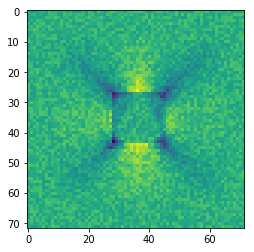

In [15]:
c = np.reshape(c, (72,72))
plt.imshow(c)

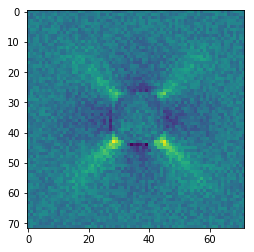

In [16]:
d = np.reshape(d, (72,72))
plt.imshow(d)

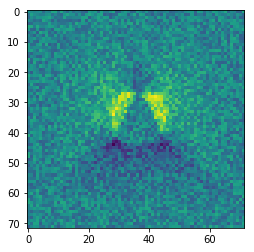

In [17]:
e = np.reshape(e, (72,72))
plt.imshow(e)

In [18]:
[X_train, Y_train] = generate_dataset_classification(1000, 20, True)
[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [19]:
Y_train = np_utils.to_categorical(Y_train, 3)

In [20]:
model = Sequential()
model.add(Dense(3, input_shape=(5184,)))
model.add(Activation('softmax'))
#sgd = SGD(lr=0.005)
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model.compile(loss='categorical_crossentropy' , optimizer=adam, metrics = ['accuracy'])
model.fit(X_train, Y_train, epochs=200, batch_size=32)

Epoch 1/200
1000/1000 [==============================] - 0s 315us/step - loss: 1.7647 - acc: 0.3910
Epoch 2/200
1000/1000 [==============================] - 0s 175us/step - loss: 0.9983 - acc: 0.5040
Epoch 3/200
1000/1000 [==============================] - 0s 162us/step - loss: 0.9389 - acc: 0.5520
Epoch 4/200
1000/1000 [==============================] - 0s 154us/step - loss: 0.8846 - acc: 0.5620
Epoch 5/200
1000/1000 [==============================] - 0s 151us/step - loss: 0.9089 - acc: 0.5760
Epoch 6/200
1000/1000 [==============================] - 0s 161us/step - loss: 0.8353 - acc: 0.5730
Epoch 7/200
1000/1000 [==============================] - 0s 219us/step - loss: 0.8401 - acc: 0.5670
Epoch 8/200
1000/1000 [==============================] - 0s 188us/step - loss: 0.8288 - acc: 0.5780
Epoch 9/200
1000/1000 [==============================] - 0s 160us/step - loss: 0.8221 - acc: 0.6190
Epoch 10/200
1000/1000 [==============================] - 0s 166us/step - loss: 0.8137 - acc: 0.5900

1000/1000 [==============================] - 0s 147us/step - loss: 0.5651 - acc: 0.7690
Epoch 83/200
1000/1000 [==============================] - 0s 144us/step - loss: 0.5584 - acc: 0.7490
Epoch 84/200
1000/1000 [==============================] - 0s 140us/step - loss: 0.5588 - acc: 0.7470
Epoch 85/200
1000/1000 [==============================] - 0s 159us/step - loss: 0.5288 - acc: 0.7640
Epoch 86/200
1000/1000 [==============================] - 0s 148us/step - loss: 0.5327 - acc: 0.7760
Epoch 87/200
1000/1000 [==============================] - 0s 148us/step - loss: 0.5505 - acc: 0.7710
Epoch 88/200
1000/1000 [==============================] - 0s 142us/step - loss: 0.8199 - acc: 0.6680
Epoch 89/200
1000/1000 [==============================] - 0s 151us/step - loss: 0.6893 - acc: 0.6890
Epoch 90/200
1000/1000 [==============================] - 0s 138us/step - loss: 0.5925 - acc: 0.7260
Epoch 91/200
1000/1000 [==============================] - 0s 153us/step - loss: 0.6513 - acc: 0.7090
Epo

1000/1000 [==============================] - 0s 139us/step - loss: 0.4019 - acc: 0.8450
Epoch 163/200
1000/1000 [==============================] - 0s 141us/step - loss: 0.4852 - acc: 0.7780
Epoch 164/200
1000/1000 [==============================] - 0s 152us/step - loss: 0.6311 - acc: 0.7030
Epoch 165/200
1000/1000 [==============================] - 0s 142us/step - loss: 0.4155 - acc: 0.8340
Epoch 166/200
1000/1000 [==============================] - 0s 139us/step - loss: 0.6057 - acc: 0.7330
Epoch 167/200
1000/1000 [==============================] - 0s 134us/step - loss: 0.4978 - acc: 0.7910
Epoch 168/200
1000/1000 [==============================] - 0s 141us/step - loss: 0.4738 - acc: 0.7910
Epoch 169/200
1000/1000 [==============================] - 0s 140us/step - loss: 0.4653 - acc: 0.8000
Epoch 170/200
1000/1000 [==============================] - 0s 141us/step - loss: 0.4136 - acc: 0.8230
Epoch 171/200
1000/1000 [==============================] - 0s 140us/step - loss: 0.4412 - acc: 0

In [21]:
model.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 277us/step


[0.8941998934745788, 0.6033333325386048]

In [22]:
print(model.metrics_names)

['loss', 'acc']


In [23]:
print(X_train.shape)

(1000, 5184)


In [24]:
X_train = X_train.reshape(X_train.shape[0], 72, 72, 1)
X_train = X_train.astype('float32' )
X_test = X_test.reshape(X_test.shape[0], 72, 72, 1)
X_test = X_test.astype('float32' )

In [25]:
print(X_train.shape)
print(X_test.shape)

(1000, 72, 72, 1)
(300, 72, 72, 1)


In [26]:
model = Sequential()
model.add(Conv2D(16, (5, 5) , input_shape=(72, 72, 1)))
print(model.output_shape)
model.add(MaxPooling2D(pool_size=(2, 2)))
print(model.output_shape)
model.add(Flatten())
print(model.output_shape)

model.add(Dense(3))

model.add(Activation('softmax'))
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model.compile(loss='categorical_crossentropy' , optimizer=adam, metrics = ['accuracy'])
model.fit(X_train, Y_train, epochs=20, batch_size=32)

(None, 68, 68, 16)
(None, 34, 34, 16)
(None, 18496)
Epoch 1/20
1000/1000 [==============================] - 4s 4ms/step - loss: 1.5988 - acc: 0.3710
Epoch 2/20
1000/1000 [==============================] - 4s 4ms/step - loss: 0.9012 - acc: 0.5850
Epoch 3/20
1000/1000 [==============================] - 4s 4ms/step - loss: 0.7920 - acc: 0.6570
Epoch 4/20
1000/1000 [==============================] - 4s 4ms/step - loss: 0.7183 - acc: 0.7240
Epoch 5/20
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6581 - acc: 0.7700
Epoch 6/20
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6184 - acc: 0.7830
Epoch 7/20
1000/1000 [==============================] - 4s 4ms/step - loss: 0.5849 - acc: 0.7850
Epoch 8/20
1000/1000 [==============================] - 4s 4ms/step - loss: 0.5555 - acc: 0.8010
Epoch 9/20
1000/1000 [==============================] - 4s 4ms/step - loss: 0.5137 - acc: 0.8310
Epoch 10/20
1000/1000 [==============================] - 4s 4ms/step - loss

In [ ]:
model.evaluate(X_test, Y_test)


In [189]:
[X_train, Y_train] = generate_dataset_regression(1000, 20)
[X_test, Y_test] = generate_test_set_regression()


Creating data:
0
100
200
300
400
500
600
700
800
900
Creating data:
0
100
200


In [190]:
print(X_test.shape)

(300, 5184)


In [191]:
X_train = np.reshape(X_train, (X_train.shape[0], 72, 72, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 72, 72, 1))

In [192]:
print(X_train.shape)

(1000, 72, 72, 1)


In [193]:
def sort_vertixes(a):
    b = np.zeros(6)
    d = {}
    for i in range(0,6,2):
        d[a[i]] = a[i+1]
    sorted_xs = np.sort(a[::2])
    for i in range(6):
        if i%2 == 0:
            b[i] = sorted_xs[int(i/2)]
        else:
            b[i] = d[sorted_xs[int((i-1)/2)]]
    return b

In [194]:
for i in range(5):
    print(Y_train[i])

[0.72943124 0.67620357 0.87875788 0.03205671 0.03637192 0.61275776]
[0.1803673  0.80084196 0.28060382 0.79669835 0.68789914 0.46490577]
[0.70018063 0.07182965 0.14081192 0.9349594  0.02901944 0.84439778]
[0.99504021 0.57890394 0.42222426 0.98647199 0.52398665 0.66998795]
[0.88866095 0.533953   0.43230493 0.15554927 0.59587053 0.85120258]


In [195]:
for i in range(Y_train.shape[0]):
    Y_train[i] = sort_vertixes(Y_train[i])
for i in range(Y_test.shape[0]):
    Y_test[i] = sort_vertixes(Y_test[i])


In [196]:
for i in range(5):
    print(Y_train[i])

[0.03637192 0.61275776 0.72943124 0.67620357 0.87875788 0.03205671]
[0.1803673  0.80084196 0.28060382 0.79669835 0.68789914 0.46490577]
[0.02901944 0.84439778 0.14081192 0.9349594  0.70018063 0.07182965]
[0.42222426 0.98647199 0.52398665 0.66998795 0.99504021 0.57890394]
[0.43230493 0.15554927 0.59587053 0.85120258 0.88866095 0.533953  ]


In [197]:
print(Y_train[0])

[0.03637192 0.61275776 0.72943124 0.67620357 0.87875788 0.03205671]


In [198]:
model = Sequential()
model.add(Conv2D(8, (3,3) , padding = 'same', activation = 'relu', input_shape=(72, 72, 1)))
print(model.output_shape)

model.add(MaxPooling2D(pool_size=(2, 2)))
print(model.output_shape)

model.add(Dropout(0.25))
print(model.output_shape)

model.add(Conv2D(16, (3,3) , padding = 'same', activation = 'relu', input_shape=(72, 72, 1)))
print(model.output_shape)

model.add(MaxPooling2D(pool_size=(2, 2)))
print(model.output_shape)

model.add(Dropout(0.25))
print(model.output_shape)

model.add(Conv2D(32, (3,3) , padding = 'same', activation = 'relu', input_shape=(72, 72, 1)))
print(model.output_shape)

model.add(MaxPooling2D(pool_size=(2, 2)))
print(model.output_shape)

model.add(Dropout(0.25))
print(model.output_shape)

model.add(Conv2D(64, (3,3) , padding = 'same', activation = 'relu', input_shape=(72, 72, 1)))
print(model.output_shape)

model.add(MaxPooling2D(pool_size=(2, 2)))
print(model.output_shape)

model.add(Dropout(0.25))
print(model.output_shape)

model.add(Flatten())
print(model.output_shape)
model.add(Dense(6, activation = 'sigmoid'))
print(model.output_shape)



(None, 72, 72, 8)
(None, 36, 36, 8)
(None, 36, 36, 8)
(None, 36, 36, 16)
(None, 18, 18, 16)
(None, 18, 18, 16)
(None, 18, 18, 32)
(None, 9, 9, 32)
(None, 9, 9, 32)
(None, 9, 9, 64)
(None, 4, 4, 64)
(None, 4, 4, 64)
(None, 1024)
(None, 6)


In [199]:
model.compile(loss='mean_squared_error' , optimizer='adam')
model.fit(X_train, Y_train, epochs=10, batch_size=32)

Epoch 1/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0684
Epoch 2/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0635
Epoch 3/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0529
Epoch 4/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0355
Epoch 5/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0302
Epoch 6/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0272
Epoch 7/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0248A: 1s - loss
Epoch 8/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0232
Epoch 9/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0219
Epoch 10/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0206


In [200]:
model.evaluate(X_test, Y_test)

300/300 [==============================] - 1s 3ms/step


0.018365977630019188

In [201]:
Y_pred = model.predict(X_test)

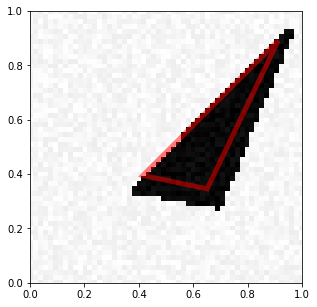

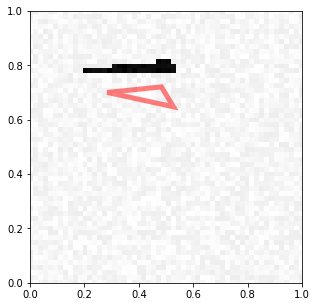

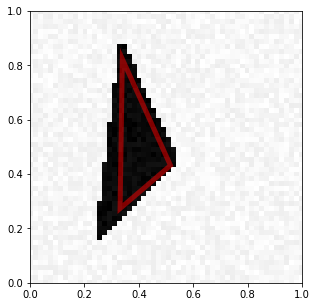

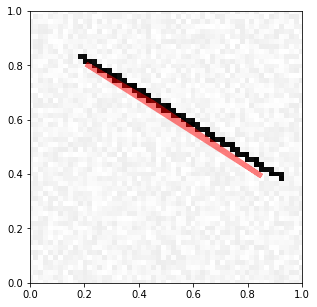

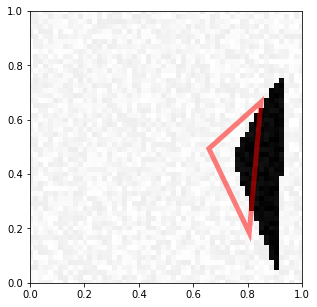

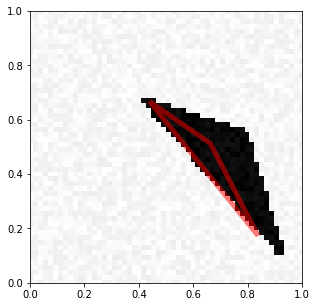

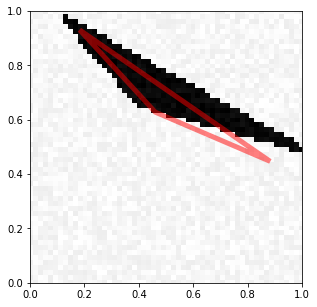

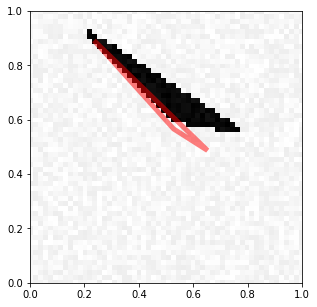

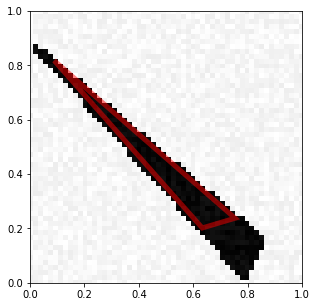

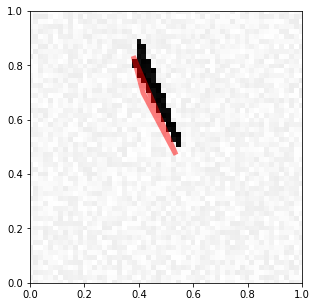

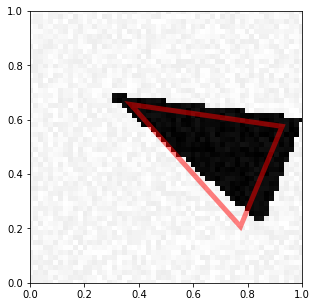

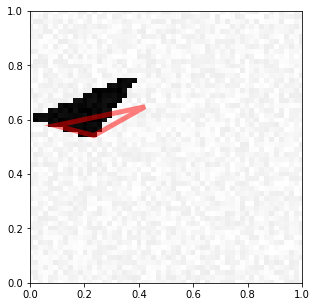

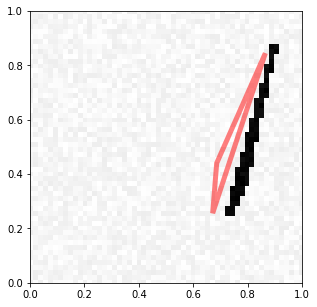

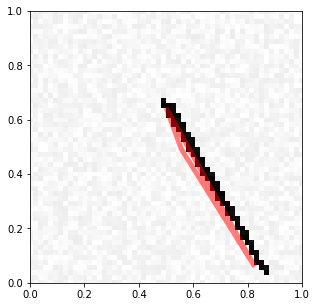

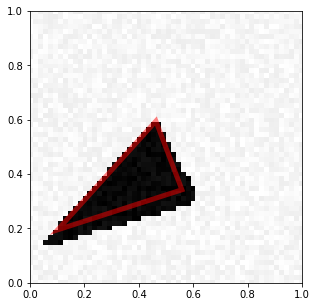

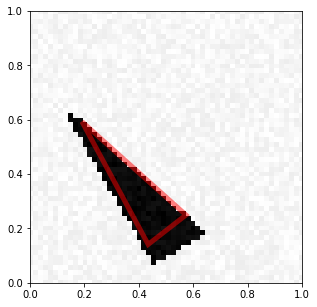

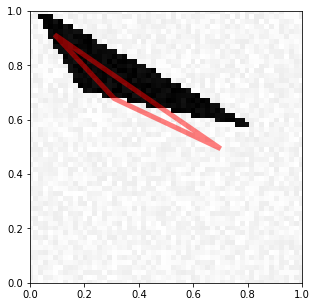

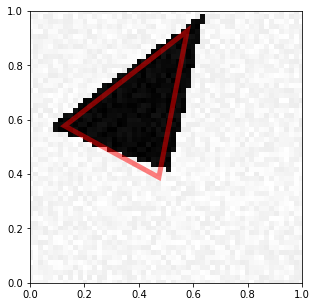

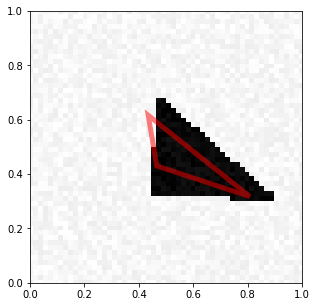

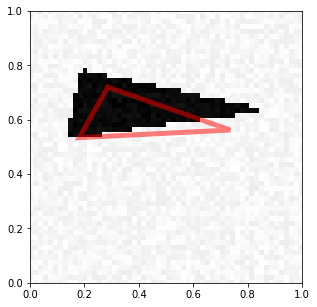

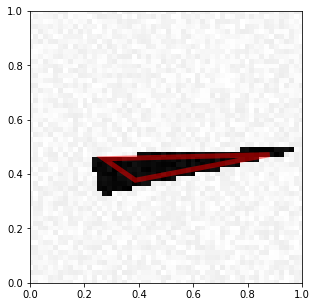

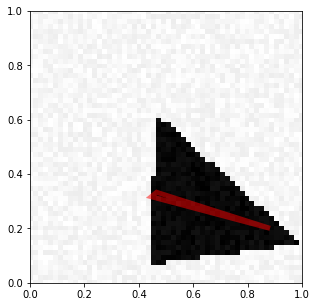

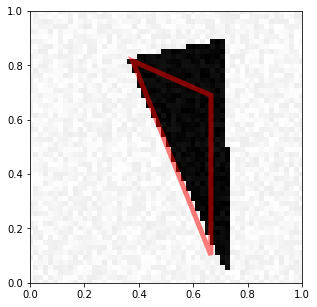

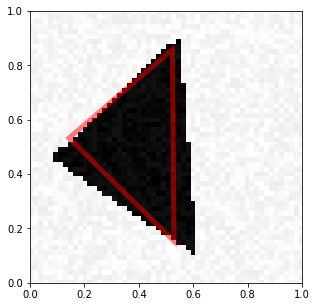

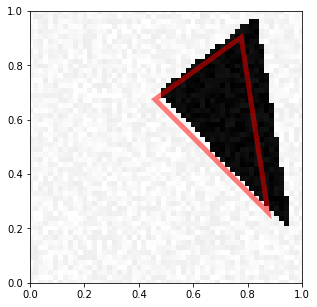

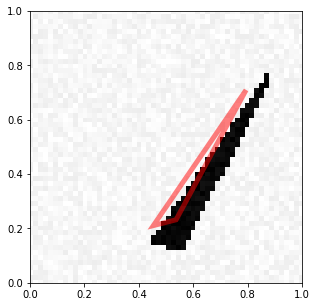

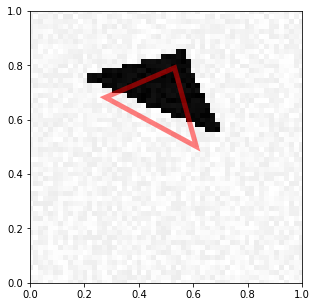

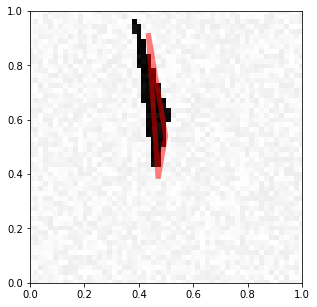

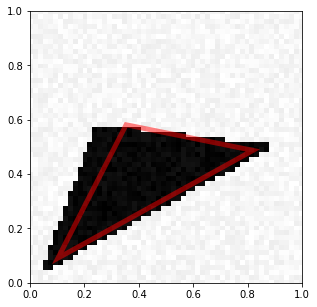

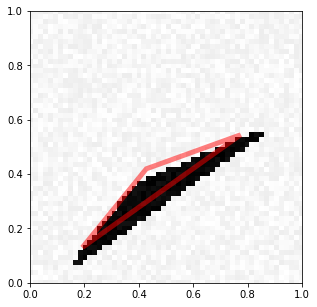

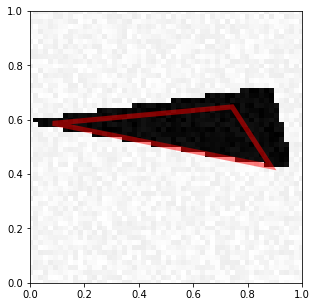

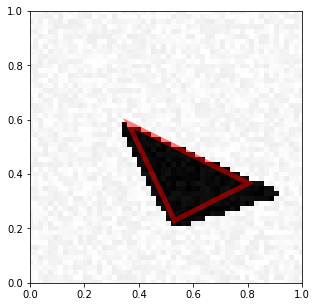

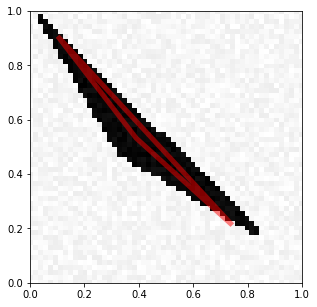

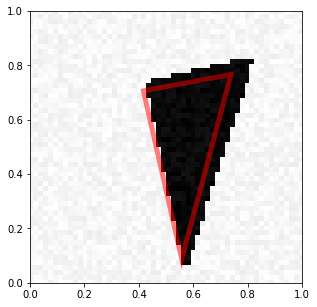

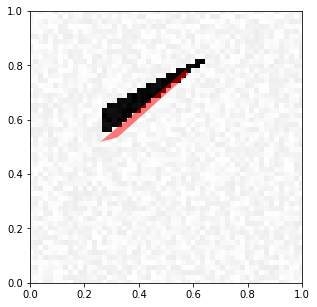

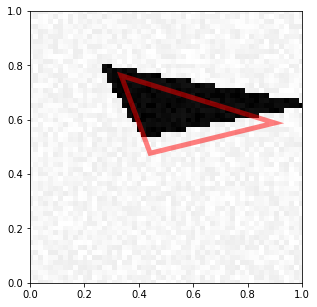

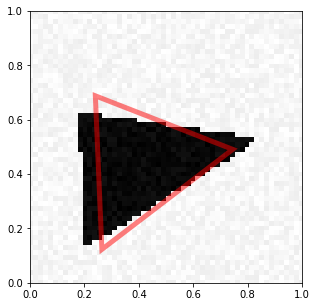

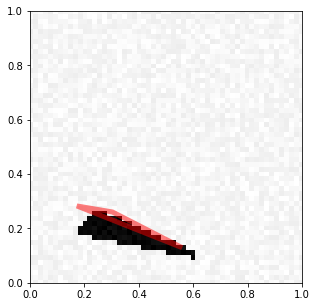

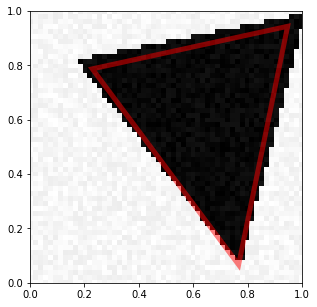

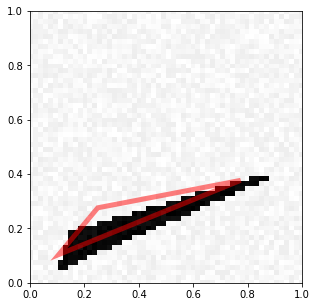

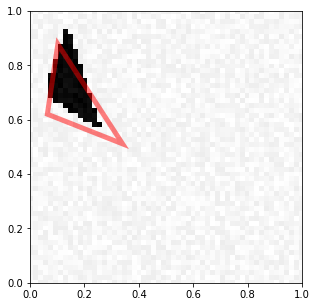

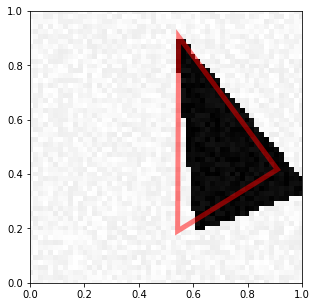

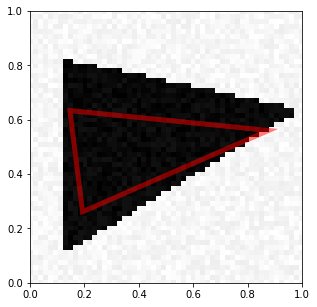

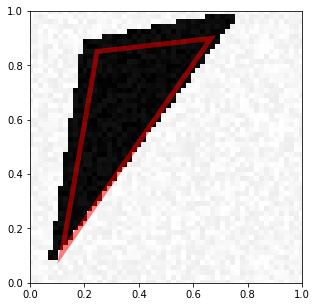

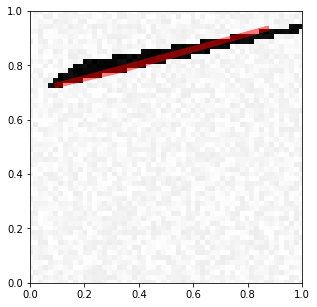

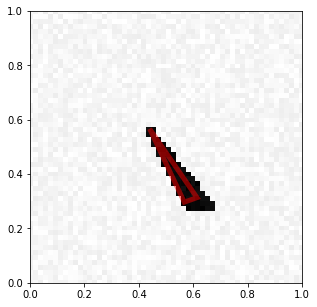

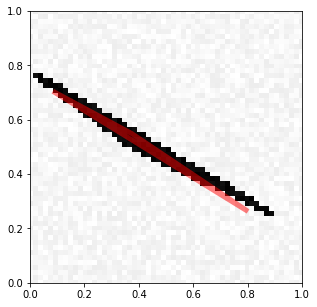

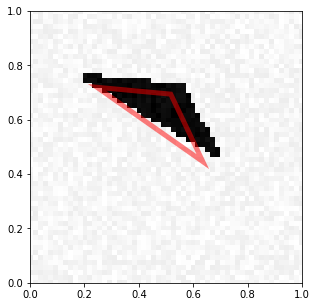

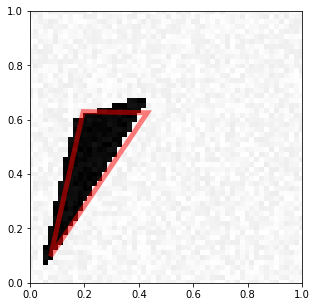

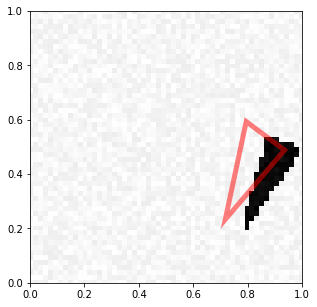

In [188]:
for i in range(50):
    visualize_prediction(X_test[i], Y_pred[i])


In [27]:
def generate_dataset_denoising(nb_samples, max_noise=0.0, free_location=True):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, im_size])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            Y[i] = generate_a_rectangle(0, free_location)
        elif category == 1: 
            Y[i] = generate_a_disk(0, free_location)
        else:
            [Y[i], V] = generate_a_triangle(0, free_location)
            
        temp_noise = np.random.randint(max_noise)
        X[i] = (Y[i] + temp_noise * np.random.random(X.shape[1])) / (255 + 2 * temp_noise)
    Y = Y/255
    return [X, Y]

In [28]:
X_train, Y_train = generate_dataset_denoising(1000, 400)

Creating data:
0
100
200
300
400
500
600
700
800
900


In [29]:
print(X_train.shape)
print(Y_train.shape)

(1000, 5184)
(1000, 5184)


In [30]:
X_train = np.reshape(X_train, (X_train.shape[0], 72 , 72, 1))
Y_train = np.reshape(Y_train, (Y_train.shape[0], 72 , 72, 1))

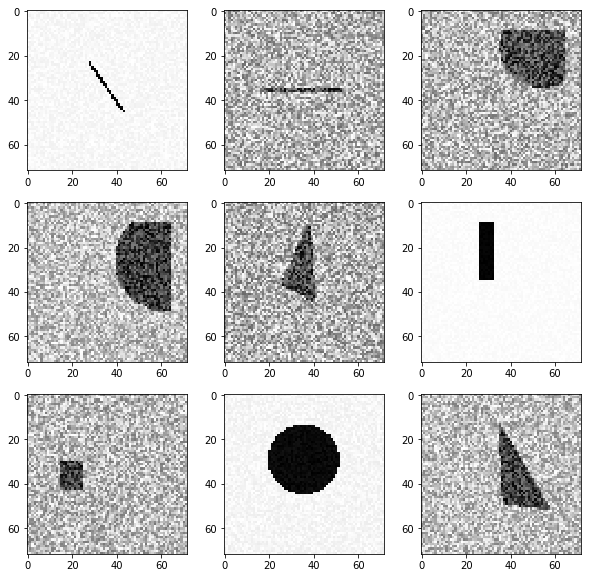

In [31]:
fig = plt.figure(figsize=(10,10))
for i in range(9):
    ax = plt.subplot("33"+str(i))
    ax.imshow(X_train[i].reshape(72,72), cmap='gray')

In [65]:
model = Sequential()
model.add(Conv2D(16, (3,3) , padding = 'same', activation = 'relu', input_shape=(72, 72, 1)))
print(model.output_shape)
model.add(MaxPooling2D(pool_size=(2, 2)))
print(model.output_shape)

model.add(Conv2D(32,  (3,3) , padding = 'same' , activation = 'relu'))
print(model.output_shape)
model.add(MaxPooling2D(pool_size=(2, 2)))
print(model.output_shape)

model.add(Conv2D(64,  (3,3) , padding = 'same' , activation = 'relu'))
print(model.output_shape)
model.add(MaxPooling2D(pool_size=(2, 2)))
print(model.output_shape)

model.add(Conv2DTranspose(64, (3,3), strides=(2, 2), padding='same', activation = 'relu'))
print(model.output_shape)

model.add(Conv2DTranspose(32, (3,3), strides=(2, 2), padding='same', activation = 'relu'))
print(model.output_shape)

model.add(Conv2DTranspose(32, (3,3), strides=(2, 2), padding='same', activation = 'relu'))
print(model.output_shape)

model.add(Conv2DTranspose(1, (3,3), strides=(1, 1), padding='same', activation = 'sigmoid'))
print(model.output_shape)



(None, 72, 72, 16)
(None, 36, 36, 16)
(None, 36, 36, 32)
(None, 18, 18, 32)
(None, 18, 18, 64)
(None, 9, 9, 64)
(None, 18, 18, 64)
(None, 36, 36, 32)
(None, 72, 72, 16)
(None, 72, 72, 1)


In [66]:
model.compile(loss='binary_crossentropy' , optimizer='adam')
model.fit(X_train, Y_train, epochs=15, batch_size=32)

Epoch 1/15
1000/1000 [==============================] - 15s 15ms/step - loss: 0.4469
Epoch 2/15
1000/1000 [==============================] - 14s 14ms/step - loss: 0.2229
Epoch 3/15
1000/1000 [==============================] - 14s 14ms/step - loss: 0.1081
Epoch 4/15
1000/1000 [==============================] - 14s 14ms/step - loss: 0.0894
Epoch 5/15
1000/1000 [==============================] - 14s 14ms/step - loss: 0.0651
Epoch 6/15
1000/1000 [==============================] - 14s 14ms/step - loss: 0.0332
Epoch 7/15
1000/1000 [==============================] - 14s 14ms/step - loss: 0.0260
Epoch 8/15
1000/1000 [==============================] - 14s 14ms/step - loss: 0.0221
Epoch 9/15
1000/1000 [==============================] - 14s 14ms/step - loss: 0.0202
Epoch 10/15
1000/1000 [==============================] - 14s 14ms/step - loss: 0.0187
Epoch 11/15
1000/1000 [==============================] - 14s 14ms/step - loss: 0.0170
Epoch 12/15
1000/1000 [==============================] - 14s 14

In [67]:
X_test, Y_test = generate_dataset_denoising(200, 400)
X_test = np.reshape(X_test, (X_test.shape[0],72,72,1))
Y_test = np.reshape(Y_test, (Y_test.shape[0],72,72,1))

Creating data:
0
100


In [68]:
model.evaluate(X_test, Y_test)

200/200 [==============================] - 1s 6ms/step


0.01551206298172474

In [69]:
print(model.metrics_names)

['loss']


In [70]:
Y = model.predict(X_test)

In [71]:
print(Y.shape)

(200, 72, 72, 1)


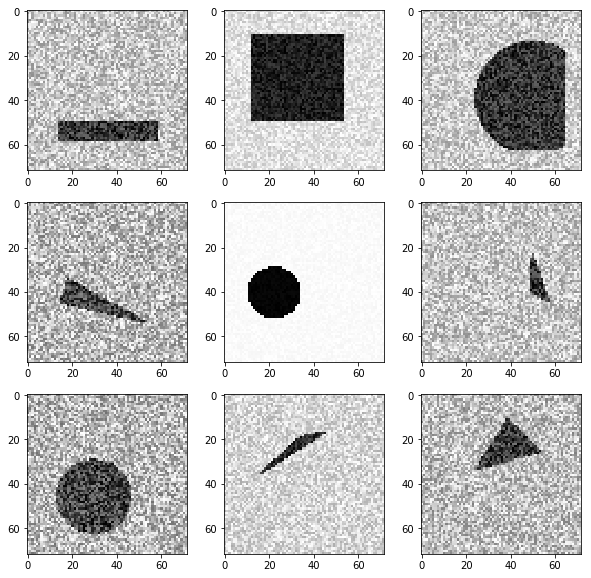

In [72]:
fig = plt.figure(figsize=(10,10))
for i in range(9):
    ax = plt.subplot("33"+str(i))
    ax.imshow(X_test[i].reshape(72,72), cmap='gray')

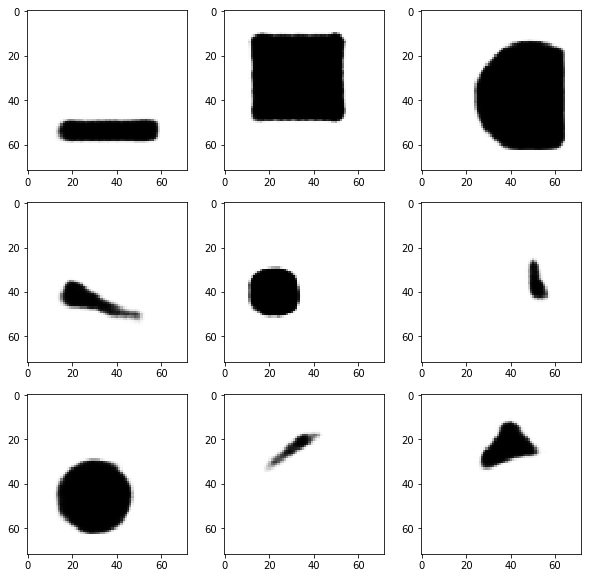

In [74]:
fig = plt.figure(figsize=(10,10))
for i in range(9):
    ax = plt.subplot("33"+str(i))
    ax.imshow(Y[i].reshape(72,72), cmap='gray')